# Section Alignment to Reference 

In [1]:
import sys
sys.path.insert(0,'../') # add code directory to path
# import lddmm
import torch_lddmm
# import numpy
import numpy as np
# import nibabel for i/o
import nibabel as nib
# import matplotlib for display
import matplotlib.pyplot as plt
import torch

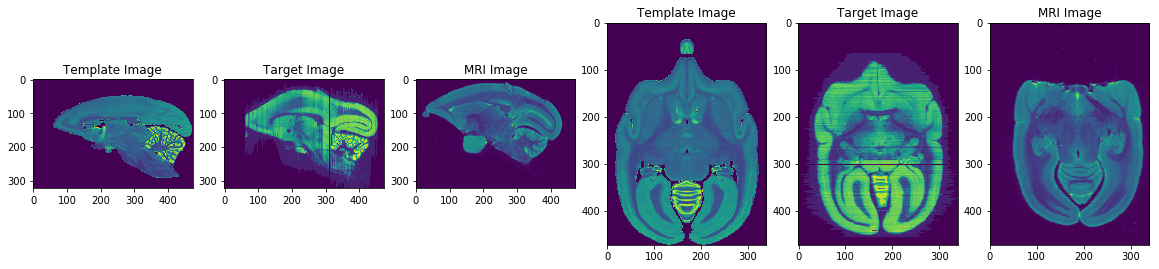

In [2]:
# load mouse brain histology images
template_file_name = '../notebook/marmoset_atlas.img'
target_file_name = '../notebook/marmoset_target.img'
mri_file_name = '../notebook/marmoset_mri.img'

template_image_struct = nib.load(template_file_name)
target_image_struct = nib.load(target_file_name)
mri_image_struct = nib.load(mri_file_name)
dx = target_image_struct.header['pixdim'][1:4]

# load into numpy arrays
template_image = np.squeeze(template_image_struct.get_data()).astype(np.float32)
target_image = np.squeeze(target_image_struct.get_data()).astype(np.float32)
mri_image = np.squeeze(mri_image_struct.get_data()).astype(np.float32)

# display slices
plt.rcParams["figure.figsize"]=20,20
plt.figure()
plt.subplot(1,6,1)
plt.imshow(template_image[:,:,150])
plt.title('Template Image')
plt.subplot(1,6,2)
plt.imshow(target_image[:,:,150])
plt.title('Target Image')
plt.subplot(1,6,3)
plt.imshow(mri_image[:,:,150])
plt.title('MRI Image')
plt.subplot(1,6,4)
plt.imshow(template_image[150,:,:])
plt.title('Template Image')
plt.subplot(1,6,5)
plt.imshow(target_image[150,:,:])
plt.title('Target Image')
plt.subplot(1,6,6)
plt.imshow(mri_image[150,:,:])
plt.title('MRI Image')
plt.show()

## Randomly scramble the target image

In [3]:
device='cuda:0'
#target = torch.Tensor(target_image).type(torch.FloatTensor).to(device=device)
#template = torch.Tensor(template_image).type(torch.FloatTensor).to(device=device)
#mri = torch.Tensor(mri_image).type(torch.FloatTensor).to(device=device)

# create lddmm object
lddmm = torch_lddmm.LDDMM(template=[template_image],target=[target_image],costmask=None,outdir='../notebook/',do_affine=2,do_lddmm=0,a=8,niter=150,epsilon=5e-3,sigma=[20.0],sigmaR=10.0,optimizer='gdr',dx=dx,cc=1)
lddmm._checkParameters()


Current parameters:
>    a               = 8 (smoothing kernel, a*(pixel_size))
>    p               = 2 (smoothing kernel power, p*2)
>    niter           = 150 (number of iterations)
>    epsilon         = 0.005 (gradient descent step size)
>    epsilonL        = 1e-07 (gradient descent step size, affine)
>    epsilonT        = 2e-05 (gradient descent step size, translation)
>    minbeta         = 0.0001 (smallest multiple of epsilon)
>    sigma           = [20.0] (matching term coefficient (0.5/sigma**2))
>    sigmaR          = 10.0 (regularization term coefficient (0.5/sigmaR**2))
>    nt              = 5 (number of time steps in velocity field)
>    do_lddmm        = 0 (perform LDDMM step, 0 = no, 1 = yes)
>    do_affine       = 2 (interleave linear registration: 0 = no, 1 = affine, 2 = rigid)
>    checkaffinestep = 0 (evaluate linear matching energy: 0 = no, 1 = yes)
>    im_norm_ms      = 0 (normalize image by mean and std: 0 = no, 1 = yes)
>    gpu_number      = 0 (index of CU

1

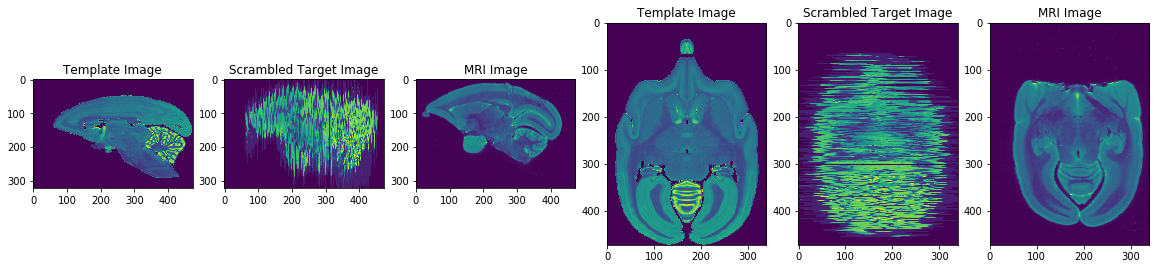

In [4]:
a = torch.Tensor(3.0*(np.random.rand(target_image.shape[1],1)-0.5)).type(torch.FloatTensor).to(device=device)
b = torch.Tensor(3.0*(np.random.rand(target_image.shape[1],1)-0.5)).type(torch.FloatTensor).to(device=device)
theta = torch.Tensor(1.5*(np.random.rand(target_image.shape[1],1)-0.5)).type(torch.FloatTensor).to(device=device)
outtarget = torch.transpose(lddmm.applySA(torch.Tensor(target_image).type(torch.FloatTensor).to(device=device), a, b, theta, dim=1,nx=list(target_image.shape),dx=[0.08,0.08,0.08]),2,1).cpu().numpy().astype(np.float32)

# display slices
plt.rcParams["figure.figsize"]=20,20
plt.figure()
plt.subplot(1,6,1)
plt.imshow(template_image[:,:,150])
plt.title('Template Image')
plt.subplot(1,6,2)
plt.imshow(outtarget[:,:,150])
plt.title('Scrambled Target Image')
plt.subplot(1,6,3)
plt.imshow(mri_image[:,:,150])
plt.title('MRI Image')
plt.subplot(1,6,4)
plt.imshow(template_image[150,:,:])
plt.title('Template Image')
plt.subplot(1,6,5)
plt.imshow(outtarget[150,:,:])
plt.title('Scrambled Target Image')
plt.subplot(1,6,6)
plt.imshow(mri_image[150,:,:])
plt.title('MRI Image')
plt.show()

## Do basic alignment of target to self

In [5]:
a = None
b = None
theta = None
missingslices = []
for i in range(target_image.shape[1]):
    if np.unique(target_image[:,i,:]).shape[0] < 3:
        missingslices.append(i)

a,b,theta,outtarget,epsilonxy,epsilontheta = lddmm.sa(torch.tensor(target_image).type(torch.FloatTensor).to(device=device),torch.tensor(mri_image).type(torch.FloatTensor).to(device=device),niter=200,dim=1,norm=0,missingslices=missingslices,sigma_atlas=9999999.0,sigma_target=50.0,a=a,b=b,theta=theta,nx=list(target_image.shape),dx=[0.08,0.08,0.08],epsilonxy=4e-8, epsilontheta=2e-8)

iter: 1, E= 67207.273, Eim_t= 67207.273, Eim_a= 0.000, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000.
iter: 2, E= 67187.797, Eim_t= 67187.797, Eim_a= 0.000, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 0.46.
iter: 3, E= 67044.055, Eim_t= 67044.055, Eim_a= 0.000, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 0.48.
iter: 4, E= 67034.414, Eim_t= 67034.414, Eim_a= 0.000, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 0.47.
iter: 5, E= 67026.609, Eim_t= 67026.609, Eim_a= 0.000, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 0.52.
iter: 6, E= 67016.695, Eim_t= 67016.695, Eim_a= 0.000, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 0.49.
iter: 7, E= 66965.547, Eim_t= 66965.547, Eim_a= 0.000, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 0.48.
iter: 8, E= 66956.875, Eim_t= 66956.875, Eim_a= 0.000, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 0.46.
iter: 9, E= 66964.80

iter: 67, E= 66738.906, Eim_t= 66738.906, Eim_a= 0.000, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 0.47.
iter: 68, E= 66735.000, Eim_t= 66735.000, Eim_a= 0.000, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 0.46.
iter: 69, E= 66735.094, Eim_t= 66735.094, Eim_a= 0.000, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 0.47.
iter: 70, E= 66731.031, Eim_t= 66731.031, Eim_a= 0.000, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 0.46.
iter: 71, E= 66729.039, Eim_t= 66729.039, Eim_a= 0.000, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 0.48.
iter: 72, E= 66725.477, Eim_t= 66725.477, Eim_a= 0.000, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 0.48.
iter: 73, E= 66722.305, Eim_t= 66722.305, Eim_a= 0.000, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 0.50.
iter: 74, E= 66719.258, Eim_t= 66719.258, Eim_a= 0.000, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 0.46.


iter: 133, E= 66592.258, Eim_t= 66592.258, Eim_a= 0.000, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 0.51.
iter: 134, E= 66587.883, Eim_t= 66587.883, Eim_a= 0.000, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 0.46.
iter: 135, E= 66586.906, Eim_t= 66586.906, Eim_a= 0.000, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 0.48.
iter: 136, E= 66582.469, Eim_t= 66582.469, Eim_a= 0.000, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 0.47.
iter: 137, E= 66581.484, Eim_t= 66581.484, Eim_a= 0.000, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 0.48.
iter: 138, E= 66576.984, Eim_t= 66576.984, Eim_a= 0.000, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 0.47.
iter: 139, E= 66576.000, Eim_t= 66576.000, Eim_a= 0.000, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 0.48.
iter: 140, E= 66571.406, Eim_t= 66571.406, Eim_a= 0.000, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time

iter: 199, E= 66468.031, Eim_t= 66468.031, Eim_a= 0.000, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 0.48.


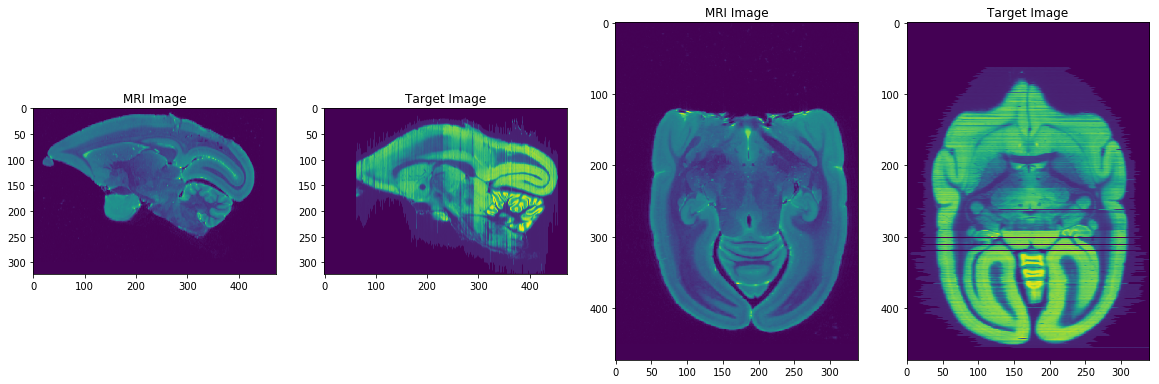

In [6]:
outtarget_np = torch.transpose(outtarget,2,1).cpu().numpy()

plt.figure()
plt.subplot(1,4,1)
plt.imshow(mri_image[:,:,150])
plt.title('MRI Image')
plt.subplot(1,4,2)
plt.imshow(torch.transpose(outtarget,2,1)[:,:,150].cpu().numpy())
plt.title('Target Image')
plt.subplot(1,4,3)
plt.imshow(mri_image[150,:,:])
plt.title('MRI Image')
plt.subplot(1,4,4)
plt.imshow(torch.transpose(outtarget,2,1)[150,:,:].cpu().numpy())
plt.title('Target Image')
plt.show()

## Rigidly align MRI to target

In [7]:
lddmm = torch_lddmm.LDDMM(template=[mri_image],target=[outtarget_np],costmask=None,outdir='../notebook/',do_affine=2,do_lddmm=0,a=8,niter=150,epsilon=5e-3,epsilonL=1e-99,epsilonT=2e-05,sigma=[20.0],sigmaR=10.0,optimizer='gdr',dx=dx,cc=1,update_epsilon=0)


Current parameters:
>    a               = 8 (smoothing kernel, a*(pixel_size))
>    p               = 2 (smoothing kernel power, p*2)
>    niter           = 150 (number of iterations)
>    epsilon         = 0.005 (gradient descent step size)
>    epsilonL        = 1e-99 (gradient descent step size, affine)
>    epsilonT        = 2e-05 (gradient descent step size, translation)
>    minbeta         = 0.0001 (smallest multiple of epsilon)
>    sigma           = [20.0] (matching term coefficient (0.5/sigma**2))
>    sigmaR          = 10.0 (regularization term coefficient (0.5/sigmaR**2))
>    nt              = 5 (number of time steps in velocity field)
>    do_lddmm        = 0 (perform LDDMM step, 0 = no, 1 = yes)
>    do_affine       = 2 (interleave linear registration: 0 = no, 1 = affine, 2 = rigid)
>    checkaffinestep = 0 (evaluate linear matching energy: 0 = no, 1 = yes)
>    im_norm_ms      = 0 (normalize image by mean and std: 0 = no, 1 = yes)
>    gpu_number      = 0 (index of CU

In [8]:
#lddmm.setParams('epsilonL',1e-99)
lddmm.run()

iter: 0, E = 62483.7422, ER = 0.0000, EM = 62483.7422, epd = 0.005000.
iter: 1, E= 60792.855, ER= 0.000, EM= 60792.855, epd= 0.005, time= 1.60s.
iter: 2, E= 57191.859, ER= 0.000, EM= 57191.859, epd= 0.005, time= 1.58s.
iter: 3, E= 50639.945, ER= 0.000, EM= 50639.945, epd= 0.005, time= 1.56s.
iter: 4, E= 40316.023, ER= 0.000, EM= 40316.023, epd= 0.005, time= 1.56s.
iter: 5, E= 31885.994, ER= 0.000, EM= 31885.994, epd= 0.005, time= 1.56s.
iter: 6, E= 39415.410, ER= 0.000, EM= 39415.410, epd= 0.005, time= 1.56s.
iter: 7, E= 44246.645, ER= 0.000, EM= 44246.645, epd= 0.005, time= 1.56s.
iter: 8, E= 45192.043, ER= 0.000, EM= 45192.043, epd= 0.005, time= 1.56s.
iter: 9, E= 44173.219, ER= 0.000, EM= 44173.219, epd= 0.005, time= 1.57s.
iter: 10, E= 42077.320, ER= 0.000, EM= 42077.320, epd= 0.005, time= 1.56s.
iter: 11, E= 39707.590, ER= 0.000, EM= 39707.590, epd= 0.005, time= 1.56s.
iter: 12, E= 37985.930, ER= 0.000, EM= 37985.930, epd= 0.005, time= 1.56s.
iter: 13, E= 37646.070, ER= 0.000, EM=

iter: 109, E= 28495.727, ER= 0.000, EM= 28495.727, epd= 0.005, time= 1.57s.
iter: 110, E= 28461.705, ER= 0.000, EM= 28461.705, epd= 0.005, time= 1.56s.
iter: 111, E= 28439.820, ER= 0.000, EM= 28439.820, epd= 0.005, time= 1.58s.
iter: 112, E= 28430.592, ER= 0.000, EM= 28430.592, epd= 0.005, time= 1.56s.
iter: 113, E= 28434.592, ER= 0.000, EM= 28434.592, epd= 0.005, time= 1.57s.
iter: 114, E= 28431.479, ER= 0.000, EM= 28431.479, epd= 0.005, time= 1.56s.
iter: 115, E= 28376.621, ER= 0.000, EM= 28376.621, epd= 0.005, time= 1.58s.
iter: 116, E= 28327.773, ER= 0.000, EM= 28327.773, epd= 0.005, time= 1.56s.
iter: 117, E= 28285.145, ER= 0.000, EM= 28285.145, epd= 0.005, time= 1.58s.
iter: 118, E= 28248.934, ER= 0.000, EM= 28248.934, epd= 0.005, time= 1.56s.
iter: 119, E= 28219.377, ER= 0.000, EM= 28219.377, epd= 0.005, time= 1.57s.
iter: 120, E= 28196.723, ER= 0.000, EM= 28196.723, epd= 0.005, time= 1.56s.
iter: 121, E= 28181.232, ER= 0.000, EM= 28181.232, epd= 0.005, time= 1.56s.
iter: 122, E

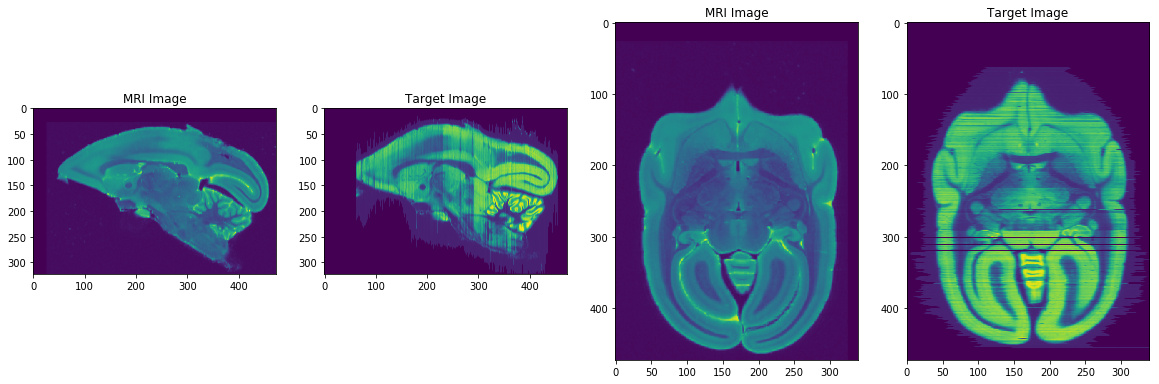

In [9]:
# apply the contrast adjustment to the MRI
mri_adjusted = (mri_image - lddmm.ccIbar[0].cpu().numpy()) * lddmm.ccCovIJ[0].cpu().numpy() / lddmm.ccVarI[0].cpu().numpy() + lddmm.ccJbar[0].cpu().numpy()
deformed_mri = (lddmm.applyThisTransform(mri_adjusted))[0][-1].cpu().numpy()

plt.figure()
plt.subplot(1,4,1)
plt.imshow(deformed_mri[:,:,150])
plt.title('MRI Image')
plt.subplot(1,4,2)
plt.imshow(outtarget_np[:,:,150])
plt.title('Target Image')
plt.subplot(1,4,3)
plt.imshow(deformed_mri[150,:,:])
plt.title('MRI Image')
plt.subplot(1,4,4)
plt.imshow(outtarget_np[150,:,:])
plt.title('Target Image')
plt.show()

In [10]:
lddmm.setParams('epsilonL',2e-7)
lddmm.setParams('epsilonT',5e-8)
#lddmm.setParams('do_affine',1)
lddmm.run()

Parameter 'epsilonL' changed to '2e-07'.
Parameter 'epsilonT' changed to '5e-08'.
iter: 0, E = 27485.2109, ER = 0.0000, EM = 27485.2109, epd = 0.005000.
iter: 1, E= 27295.236, ER= 0.000, EM= 27295.236, epd= 0.005, time= 1.58s.
iter: 2, E= 26992.416, ER= 0.000, EM= 26992.416, epd= 0.005, time= 1.56s.
iter: 3, E= 26770.496, ER= 0.000, EM= 26770.496, epd= 0.005, time= 1.58s.
iter: 4, E= 26691.672, ER= 0.000, EM= 26691.672, epd= 0.005, time= 1.56s.
iter: 5, E= 26707.070, ER= 0.000, EM= 26707.070, epd= 0.005, time= 1.58s.
iter: 6, E= 26734.174, ER= 0.000, EM= 26734.174, epd= 0.005, time= 1.56s.
iter: 7, E= 26754.000, ER= 0.000, EM= 26754.000, epd= 0.005, time= 1.58s.
iter: 8, E= 26771.377, ER= 0.000, EM= 26771.377, epd= 0.005, time= 1.56s.
iter: 9, E= 26785.967, ER= 0.000, EM= 26785.967, epd= 0.005, time= 1.58s.
iter: 10, E= 26797.510, ER= 0.000, EM= 26797.510, epd= 0.005, time= 1.56s.
iter: 11, E= 26806.154, ER= 0.000, EM= 26806.154, epd= 0.005, time= 1.58s.
iter: 12, E= 26812.395, ER= 0.0

In [11]:
lddmm.setParams('do_affine',1)
lddmm.run()

Parameter 'do_affine' changed to '1'.
iter: 0, E = 26827.4316, ER = 0.0000, EM = 26827.4316, epd = 0.005000.
iter: 1, E= 25327.369, ER= 0.000, EM= 25327.369, epd= 0.005, time= 1.56s.
iter: 2, E= 24706.271, ER= 0.000, EM= 24706.271, epd= 0.005, time= 1.57s.
iter: 3, E= 24482.662, ER= 0.000, EM= 24482.662, epd= 0.005, time= 1.56s.
iter: 4, E= 24395.107, ER= 0.000, EM= 24395.107, epd= 0.005, time= 1.57s.
iter: 5, E= 24334.906, ER= 0.000, EM= 24334.906, epd= 0.005, time= 1.56s.
iter: 6, E= 24285.791, ER= 0.000, EM= 24285.791, epd= 0.005, time= 1.57s.
iter: 7, E= 24242.344, ER= 0.000, EM= 24242.344, epd= 0.005, time= 1.56s.
iter: 8, E= 24203.000, ER= 0.000, EM= 24203.000, epd= 0.005, time= 1.58s.
iter: 9, E= 24167.064, ER= 0.000, EM= 24167.064, epd= 0.005, time= 1.56s.
iter: 10, E= 24133.070, ER= 0.000, EM= 24133.070, epd= 0.005, time= 1.57s.
iter: 11, E= 24100.111, ER= 0.000, EM= 24100.111, epd= 0.005, time= 1.56s.
iter: 12, E= 24069.121, ER= 0.000, EM= 24069.121, epd= 0.005, time= 1.57s.


iter: 108, E= 23379.762, ER= 0.000, EM= 23379.762, epd= 0.005, time= 1.57s.
iter: 109, E= 23377.902, ER= 0.000, EM= 23377.902, epd= 0.005, time= 1.56s.
iter: 110, E= 23376.041, ER= 0.000, EM= 23376.041, epd= 0.005, time= 1.58s.
iter: 111, E= 23374.184, ER= 0.000, EM= 23374.184, epd= 0.005, time= 1.56s.
iter: 112, E= 23372.342, ER= 0.000, EM= 23372.342, epd= 0.005, time= 1.58s.
iter: 113, E= 23370.512, ER= 0.000, EM= 23370.512, epd= 0.005, time= 1.56s.
iter: 114, E= 23368.684, ER= 0.000, EM= 23368.684, epd= 0.005, time= 1.58s.
iter: 115, E= 23366.871, ER= 0.000, EM= 23366.871, epd= 0.005, time= 1.56s.
iter: 116, E= 23365.062, ER= 0.000, EM= 23365.062, epd= 0.005, time= 1.57s.
iter: 117, E= 23363.254, ER= 0.000, EM= 23363.254, epd= 0.005, time= 1.56s.
iter: 118, E= 23361.447, ER= 0.000, EM= 23361.447, epd= 0.005, time= 1.58s.
iter: 119, E= 23359.650, ER= 0.000, EM= 23359.650, epd= 0.005, time= 1.57s.
iter: 120, E= 23357.857, ER= 0.000, EM= 23357.857, epd= 0.005, time= 1.57s.
iter: 121, E

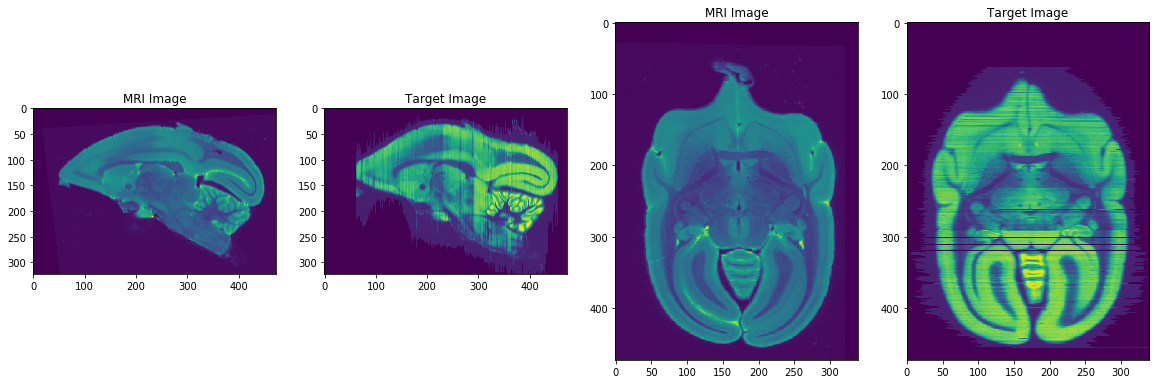

In [12]:
# apply the contrast adjustment to the MRI
mri_adjusted = (mri_image - lddmm.ccIbar[0].cpu().numpy()) * lddmm.ccCovIJ[0].cpu().numpy() / lddmm.ccVarI[0].cpu().numpy() + lddmm.ccJbar[0].cpu().numpy()
deformed_mri = (lddmm.applyThisTransform(mri_adjusted))[0][-1].cpu().numpy()

plt.figure()
plt.subplot(1,4,1)
plt.imshow(deformed_mri[:,:,150])
plt.title('MRI Image')
plt.subplot(1,4,2)
plt.imshow(outtarget_np[:,:,150])
plt.title('Target Image')
plt.subplot(1,4,3)
plt.imshow(deformed_mri[150,:,:])
plt.title('MRI Image')
plt.subplot(1,4,4)
plt.imshow(outtarget_np[150,:,:])
plt.title('Target Image')
plt.show()

In [13]:
missingslices = []
for i in range(target_image.shape[1]):
    if np.unique(target_image[:,i,:]).shape[0] < 3:
        missingslices.append(i)

print(missingslices)
epsilonxy = 2e-8
epsilontheta=1e-8
a = None
b = None
theta = None
lddmm.setParams('epsilonL',1e-7)
lddmm.setParams('epsilonT',2e-8)
nepochs = 8

# loop
for i in range(1,nepochs):
    if i == 1:
        niter = 600
    elif i < 3:
        niter = 100
    elif i == 7:
        niter = 800
    else:
        niter = 200
    
    a,b,theta,outtarget,epsilonxy,epsilontheta = lddmm.sa(torch.tensor(target_image).type(torch.FloatTensor).cuda(),torch.tensor(deformed_mri).type(torch.FloatTensor).cuda(),niter=niter,dim=1,norm=0,missingslices=missingslices,sigma_atlas=4.0,sigma_target=50.0,a=a,b=b,theta=theta,nx=list(target_image.shape),dx=[0.08,0.04,0.08],epsilonxy=epsilonxy*4, epsilontheta=epsilontheta*4)
    outtarget = torch.transpose(lddmm.applySA(torch.tensor(target_image).type(torch.FloatTensor).cuda(), a, b, theta, dim=1,nx=list(target_image.shape),dx=[0.08,0.04,0.08]),2,1).cpu().numpy().astype(np.float32)
    lddmm.setParams('energy_fraction_from',len(lddmm.EAll)-1)
    
    if i < nepochs:
        lddmm.J[0] = torch.tensor(outtarget).type(torch.FloatTensor).cuda()
        lddmm.setParams('niter',40)
        lddmm.run()
    
    # resample the mri image
    deformed_mri = (lddmm.applyThisTransform(mri_adjusted))[0][-1].cpu().numpy()

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 301, 311, 319, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472]
Parameter 'epsilonL' changed to '1e-07'.
Parameter 'epsilonT' changed to '2e-08'.
iter: 1, E= 380361.062, Eim_t= 134414.547, Eim_a= 245946.516, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000.
iter: 2, E= 378881.375, Eim_t= 133828.641, Eim_a= 245052.750, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 0.48.
iter: 3, E= 378126.000, Eim_t= 134868.625, Eim_a= 243257.375, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 0.48.
iter: 4, E= 377015.656, Eim_t= 134444.875, Eim_a= 242570.781, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 0.46.
iter: 5, E= 560692.875, Eim_t= 317098.844, Eim_a= 243594.000, E

iter: 60, E= 350893.031, Eim_t= 130693.609, Eim_a= 220199.422, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 0.46.
iter: 61, E= 350841.281, Eim_t= 130672.867, Eim_a= 220168.406, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 0.48.
iter: 62, E= 350296.219, Eim_t= 130658.742, Eim_a= 219637.484, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 0.46.
iter: 63, E= 350263.938, Eim_t= 130657.945, Eim_a= 219606.000, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 0.48.
iter: 64, E= 349699.250, Eim_t= 130651.352, Eim_a= 219047.906, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 0.46.
iter: 65, E= 349666.844, Eim_t= 130650.977, Eim_a= 219015.875, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 0.48.
iter: 66, E= 349100.062, Eim_t= 130647.062, Eim_a= 218453.000, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 0.46.
iter: 67, E= 349068.750, Eim_t= 130648.688, Eim_a= 218420.078, ER_xy= 0.000,

iter: 122, E= 335906.625, Eim_t= 131537.875, Eim_a= 204368.734, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 0.46.
iter: 123, E= 335885.625, Eim_t= 131549.125, Eim_a= 204336.516, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 0.48.
iter: 124, E= 336641.500, Eim_t= 132793.906, Eim_a= 203847.594, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 0.46.
iter: 125, E= 336620.312, Eim_t= 132809.047, Eim_a= 203811.266, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 0.48.
iter: 126, E= 335280.281, Eim_t= 131781.328, Eim_a= 203498.953, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 0.46.
iter: 127, E= 335338.625, Eim_t= 131876.328, Eim_a= 203462.281, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 0.48.
iter: 128, E= 334618.812, Eim_t= 131495.766, Eim_a= 203123.047, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 0.46.
iter: 129, E= 334407.969, Eim_t= 131311.250, Eim_a= 203096.719, ER_xy

iter: 184, E= 325734.562, Eim_t= 131288.000, Eim_a= 194446.547, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.46.
iter: 185, E= 325702.188, Eim_t= 131279.469, Eim_a= 194422.734, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.48.
iter: 186, E= 325882.375, Eim_t= 131690.188, Eim_a= 194192.172, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.46.
iter: 187, E= 325853.062, Eim_t= 131686.109, Eim_a= 194166.953, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.48.
iter: 188, E= 325103.125, Eim_t= 131106.906, Eim_a= 193996.203, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.46.
iter: 189, E= 325084.000, Eim_t= 131113.531, Eim_a= 193970.453, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.48.
iter: 190, E= 324773.688, Eim_t= 130962.555, Eim_a= 193811.125, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.46.
iter: 191, E= 324786.844, Eim_t= 130999.836, Eim_a= 193787.000, ER_xy

iter: 246, E= 319595.875, Eim_t= 130871.531, Eim_a= 188724.344, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.46.
iter: 247, E= 319583.000, Eim_t= 130871.547, Eim_a= 188711.438, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.48.
iter: 248, E= 319451.281, Eim_t= 130870.820, Eim_a= 188580.453, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.47.
iter: 249, E= 319438.156, Eim_t= 130871.008, Eim_a= 188567.156, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.48.
iter: 250, E= 319306.406, Eim_t= 130870.961, Eim_a= 188435.438, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.47.
iter: 251, E= 319293.312, Eim_t= 130871.438, Eim_a= 188421.891, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.51.
iter: 252, E= 319163.344, Eim_t= 130876.617, Eim_a= 188286.734, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.46.
iter: 253, E= 319150.375, Eim_t= 130877.469, Eim_a= 188272.891, ER_xy

iter: 308, E= 316451.312, Eim_t= 131115.828, Eim_a= 185335.469, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.50.
iter: 309, E= 316453.094, Eim_t= 131127.547, Eim_a= 185325.547, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.48.
iter: 310, E= 316683.062, Eim_t= 131444.156, Eim_a= 185238.891, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.46.
iter: 311, E= 316658.812, Eim_t= 131427.859, Eim_a= 185230.953, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.51.
iter: 312, E= 316529.219, Eim_t= 131362.000, Eim_a= 185167.219, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.47.
iter: 313, E= 316510.938, Eim_t= 131350.969, Eim_a= 185159.953, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.48.
iter: 314, E= 316459.812, Eim_t= 131358.000, Eim_a= 185101.812, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.47.
iter: 315, E= 316438.688, Eim_t= 131345.203, Eim_a= 185093.484, ER_xy

iter: 370, E= 314655.812, Eim_t= 131087.469, Eim_a= 183568.328, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.46.
iter: 371, E= 314646.375, Eim_t= 131081.156, Eim_a= 183565.219, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.48.
iter: 372, E= 314610.000, Eim_t= 131076.219, Eim_a= 183533.766, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.46.
iter: 373, E= 314604.125, Eim_t= 131073.922, Eim_a= 183530.188, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.48.
iter: 374, E= 314571.875, Eim_t= 131072.953, Eim_a= 183498.922, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.46.
iter: 375, E= 314567.812, Eim_t= 131072.234, Eim_a= 183495.562, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.48.
iter: 376, E= 314537.062, Eim_t= 131074.297, Eim_a= 183462.781, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.47.
iter: 377, E= 314532.750, Eim_t= 131073.594, Eim_a= 183459.156, ER_xy

iter: 432, E= 313627.094, Eim_t= 131126.828, Eim_a= 182500.266, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.49.
iter: 433, E= 313623.812, Eim_t= 131126.250, Eim_a= 182497.562, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.48.
iter: 434, E= 313599.312, Eim_t= 131129.891, Eim_a= 182469.422, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.47.
iter: 435, E= 313596.250, Eim_t= 131129.562, Eim_a= 182466.688, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.48.
iter: 436, E= 313572.219, Eim_t= 131134.953, Eim_a= 182437.266, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.46.
iter: 437, E= 313568.875, Eim_t= 131134.422, Eim_a= 182434.453, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.48.
iter: 438, E= 313549.750, Eim_t= 131144.656, Eim_a= 182405.094, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.47.
iter: 439, E= 313547.000, Eim_t= 131144.766, Eim_a= 182402.219, ER_xy

iter: 494, E= 313011.531, Eim_t= 131293.625, Eim_a= 181717.906, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.47.
iter: 495, E= 313006.375, Eim_t= 131290.094, Eim_a= 181716.281, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.48.
iter: 496, E= 312997.344, Eim_t= 131301.312, Eim_a= 181696.031, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.46.
iter: 497, E= 312991.500, Eim_t= 131297.531, Eim_a= 181693.969, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.48.
iter: 498, E= 313002.875, Eim_t= 131324.359, Eim_a= 181678.516, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.47.
iter: 499, E= 312998.062, Eim_t= 131321.344, Eim_a= 181676.719, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.48.
iter: 500, E= 312865.125, Eim_t= 131203.688, Eim_a= 181661.438, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.47.
iter: 501, E= 312861.000, Eim_t= 131201.578, Eim_a= 181659.422, ER_xy

iter: 556, E= 312358.312, Eim_t= 131185.344, Eim_a= 181172.953, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.47.
iter: 557, E= 312357.281, Eim_t= 131185.141, Eim_a= 181172.141, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.48.
iter: 558, E= 312345.312, Eim_t= 131186.047, Eim_a= 181159.266, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.47.
iter: 559, E= 312344.312, Eim_t= 131185.922, Eim_a= 181158.406, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.51.
iter: 560, E= 312332.000, Eim_t= 131187.031, Eim_a= 181144.953, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.47.
iter: 561, E= 312330.969, Eim_t= 131186.875, Eim_a= 181144.094, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.48.
iter: 562, E= 312318.188, Eim_t= 131187.875, Eim_a= 181130.312, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.46.
iter: 563, E= 312317.125, Eim_t= 131187.734, Eim_a= 181129.406, ER_xy

iter: 31, E= 18743.648, ER= 0.000, EM= 18743.648, epd= 0.005, time= 1.58s.
iter: 32, E= 18741.979, ER= 0.000, EM= 18741.979, epd= 0.005, time= 1.57s.
iter: 33, E= 18740.305, ER= 0.000, EM= 18740.305, epd= 0.005, time= 1.58s.
iter: 34, E= 18738.639, ER= 0.000, EM= 18738.639, epd= 0.005, time= 1.56s.
iter: 35, E= 18736.979, ER= 0.000, EM= 18736.979, epd= 0.005, time= 1.58s.
iter: 36, E= 18735.316, ER= 0.000, EM= 18735.316, epd= 0.005, time= 1.56s.
iter: 37, E= 18733.658, ER= 0.000, EM= 18733.658, epd= 0.005, time= 1.57s.
iter: 38, E= 18732.000, ER= 0.000, EM= 18732.000, epd= 0.005, time= 1.56s.
iter: 39, E= 18730.344, ER= 0.000, EM= 18730.344, epd= 0.005, time= 1.57s.
Total elapsed runtime: 61.24 seconds.
iter: 1, E= 310508.281, Eim_t= 131200.312, Eim_a= 179307.969, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000.
iter: 2, E= 310471.062, Eim_t= 131230.344, Eim_a= 179240.734, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.46.
iter: 3, E= 310467.875, Eim_t= 131234

iter: 58, E= 309970.062, Eim_t= 131246.984, Eim_a= 178723.078, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.47.
iter: 59, E= 309969.375, Eim_t= 131247.125, Eim_a= 178722.266, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.48.
iter: 60, E= 309956.062, Eim_t= 131247.984, Eim_a= 178708.094, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.47.
iter: 61, E= 309955.375, Eim_t= 131248.094, Eim_a= 178707.266, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.48.
iter: 62, E= 309941.812, Eim_t= 131248.984, Eim_a= 178692.844, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.46.
iter: 63, E= 309941.125, Eim_t= 131249.125, Eim_a= 178692.000, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.48.
iter: 64, E= 309927.438, Eim_t= 131250.469, Eim_a= 178676.969, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.46.
iter: 65, E= 309926.688, Eim_t= 131250.578, Eim_a= 178676.109, ER_xy= 0.000,

iter: 35, E= 18553.865, ER= 0.000, EM= 18553.865, epd= 0.005, time= 1.56s.
iter: 36, E= 18552.223, ER= 0.000, EM= 18552.223, epd= 0.005, time= 1.57s.
iter: 37, E= 18550.574, ER= 0.000, EM= 18550.574, epd= 0.005, time= 1.57s.
iter: 38, E= 18548.928, ER= 0.000, EM= 18548.928, epd= 0.005, time= 1.58s.
iter: 39, E= 18547.281, ER= 0.000, EM= 18547.281, epd= 0.005, time= 1.56s.
Total elapsed runtime: 61.18 seconds.
iter: 1, E= 308981.875, Eim_t= 131263.281, Eim_a= 177718.594, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000.
iter: 2, E= 308928.938, Eim_t= 131267.031, Eim_a= 177661.891, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.47.
iter: 3, E= 308925.250, Eim_t= 131268.078, Eim_a= 177657.156, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.48.
iter: 4, E= 308916.469, Eim_t= 131314.109, Eim_a= 177602.359, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.47.
iter: 5, E= 308956.719, Eim_t= 131359.109, Eim_a= 177597.609, ER_xy= 0.000,

iter: 61, E= 308506.188, Eim_t= 131287.062, Eim_a= 177219.141, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.48.
iter: 62, E= 308497.750, Eim_t= 131286.250, Eim_a= 177211.500, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.47.
iter: 63, E= 308497.125, Eim_t= 131286.062, Eim_a= 177211.062, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.49.
iter: 64, E= 308488.094, Eim_t= 131285.406, Eim_a= 177202.688, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.47.
iter: 65, E= 308487.500, Eim_t= 131285.219, Eim_a= 177202.266, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.49.
iter: 66, E= 308479.375, Eim_t= 131285.281, Eim_a= 177194.078, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.47.
iter: 67, E= 308478.812, Eim_t= 131285.234, Eim_a= 177193.594, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.48.
iter: 68, E= 308469.969, Eim_t= 131285.281, Eim_a= 177184.688, ER_xy= 0.000,

iter: 123, E= 308246.562, Eim_t= 131287.578, Eim_a= 176959.000, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.49.
iter: 124, E= 308243.188, Eim_t= 131293.609, Eim_a= 176949.594, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.47.
iter: 125, E= 308242.938, Eim_t= 131293.891, Eim_a= 176949.031, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.48.
iter: 126, E= 308246.312, Eim_t= 131305.719, Eim_a= 176940.578, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.47.
iter: 127, E= 308247.250, Eim_t= 131306.953, Eim_a= 176940.312, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.49.
iter: 128, E= 308234.562, Eim_t= 131301.172, Eim_a= 176933.375, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.47.
iter: 129, E= 308231.625, Eim_t= 131298.844, Eim_a= 176932.797, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.49.
iter: 130, E= 308221.438, Eim_t= 131294.500, Eim_a= 176926.953, ER_xy

iter: 185, E= 308059.250, Eim_t= 131321.781, Eim_a= 176737.453, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.48.
iter: 186, E= 308031.031, Eim_t= 131297.688, Eim_a= 176733.344, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.47.
iter: 187, E= 308031.031, Eim_t= 131297.750, Eim_a= 176733.281, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.49.
iter: 188, E= 308022.375, Eim_t= 131294.016, Eim_a= 176728.375, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.47.
iter: 189, E= 308021.938, Eim_t= 131294.141, Eim_a= 176727.797, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.49.
iter: 190, E= 308015.000, Eim_t= 131291.828, Eim_a= 176723.172, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.47.
iter: 191, E= 308015.688, Eim_t= 131292.516, Eim_a= 176723.172, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.49.
iter: 192, E= 308009.562, Eim_t= 131291.453, Eim_a= 176718.125, ER_xy

iter: 25, E= 307165.312, Eim_t= 131367.750, Eim_a= 175797.578, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.47.
iter: 26, E= 307164.938, Eim_t= 131372.172, Eim_a= 175792.750, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.46.
iter: 27, E= 307161.812, Eim_t= 131369.688, Eim_a= 175792.141, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.47.
iter: 28, E= 307180.312, Eim_t= 131396.359, Eim_a= 175783.969, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.47.
iter: 29, E= 307176.125, Eim_t= 131392.906, Eim_a= 175783.234, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.47.
iter: 30, E= 307091.875, Eim_t= 131312.734, Eim_a= 175779.125, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.46.
iter: 31, E= 307090.125, Eim_t= 131311.344, Eim_a= 175778.766, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.48.
iter: 32, E= 307073.250, Eim_t= 131299.938, Eim_a= 175773.328, ER_xy= 0.000,

iter: 88, E= 306905.438, Eim_t= 131296.828, Eim_a= 175608.609, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.46.
iter: 89, E= 306905.125, Eim_t= 131296.750, Eim_a= 175608.375, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.48.
iter: 90, E= 306900.750, Eim_t= 131297.203, Eim_a= 175603.531, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.46.
iter: 91, E= 306900.438, Eim_t= 131297.125, Eim_a= 175603.312, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.48.
iter: 92, E= 306895.750, Eim_t= 131297.406, Eim_a= 175598.328, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.46.
iter: 93, E= 306895.438, Eim_t= 131297.312, Eim_a= 175598.109, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.51.
iter: 94, E= 306890.812, Eim_t= 131297.875, Eim_a= 175592.922, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.46.
iter: 95, E= 306890.500, Eim_t= 131297.812, Eim_a= 175592.672, ER_xy= 0.000,

iter: 150, E= 306756.125, Eim_t= 131302.906, Eim_a= 175453.234, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.46.
iter: 151, E= 306755.844, Eim_t= 131302.797, Eim_a= 175453.047, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.48.
iter: 152, E= 306750.750, Eim_t= 131303.453, Eim_a= 175447.312, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.48.
iter: 153, E= 306750.375, Eim_t= 131303.344, Eim_a= 175447.047, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.48.
iter: 154, E= 306744.750, Eim_t= 131303.656, Eim_a= 175441.109, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.46.
iter: 155, E= 306744.531, Eim_t= 131303.609, Eim_a= 175440.922, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.48.
iter: 156, E= 306740.188, Eim_t= 131305.391, Eim_a= 175434.797, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.46.
iter: 157, E= 306740.031, Eim_t= 131305.562, Eim_a= 175434.469, ER_xy

iter: 20, E= 18183.531, ER= 0.000, EM= 18183.531, epd= 0.005, time= 1.57s.
iter: 21, E= 18181.859, ER= 0.000, EM= 18181.859, epd= 0.005, time= 1.57s.
iter: 22, E= 18180.195, ER= 0.000, EM= 18180.195, epd= 0.005, time= 1.56s.
iter: 23, E= 18178.525, ER= 0.000, EM= 18178.525, epd= 0.005, time= 1.57s.
iter: 24, E= 18176.865, ER= 0.000, EM= 18176.865, epd= 0.005, time= 1.56s.
iter: 25, E= 18175.201, ER= 0.000, EM= 18175.201, epd= 0.005, time= 1.57s.
iter: 26, E= 18173.537, ER= 0.000, EM= 18173.537, epd= 0.005, time= 1.57s.
iter: 27, E= 18171.873, ER= 0.000, EM= 18171.873, epd= 0.005, time= 1.56s.
iter: 28, E= 18170.211, ER= 0.000, EM= 18170.211, epd= 0.005, time= 1.57s.
iter: 29, E= 18168.545, ER= 0.000, EM= 18168.545, epd= 0.005, time= 1.57s.
iter: 30, E= 18166.889, ER= 0.000, EM= 18166.889, epd= 0.005, time= 1.57s.
iter: 31, E= 18165.229, ER= 0.000, EM= 18165.229, epd= 0.005, time= 1.57s.
iter: 32, E= 18163.566, ER= 0.000, EM= 18163.566, epd= 0.005, time= 1.57s.
iter: 33, E= 18161.904, E

iter: 52, E= 305786.719, Eim_t= 131316.578, Eim_a= 174470.141, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.46.
iter: 53, E= 305786.438, Eim_t= 131316.516, Eim_a= 174469.938, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.47.
iter: 54, E= 305782.375, Eim_t= 131316.516, Eim_a= 174465.875, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.50.
iter: 55, E= 305782.219, Eim_t= 131316.500, Eim_a= 174465.719, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.48.
iter: 56, E= 305778.438, Eim_t= 131316.953, Eim_a= 174461.500, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.46.
iter: 57, E= 305778.188, Eim_t= 131316.891, Eim_a= 174461.281, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.48.
iter: 58, E= 305773.812, Eim_t= 131316.828, Eim_a= 174457.000, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.46.
iter: 59, E= 305773.688, Eim_t= 131316.859, Eim_a= 174456.812, ER_xy= 0.000,

iter: 114, E= 305672.688, Eim_t= 131322.344, Eim_a= 174350.328, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.46.
iter: 115, E= 305672.562, Eim_t= 131322.375, Eim_a= 174350.172, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.47.
iter: 116, E= 305670.875, Eim_t= 131325.484, Eim_a= 174345.391, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.46.
iter: 117, E= 305670.844, Eim_t= 131325.719, Eim_a= 174345.125, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.48.
iter: 118, E= 305675.469, Eim_t= 131334.672, Eim_a= 174340.797, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.46.
iter: 119, E= 305676.750, Eim_t= 131336.078, Eim_a= 174340.672, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.47.
iter: 120, E= 305676.875, Eim_t= 131339.766, Eim_a= 174337.094, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.46.
iter: 121, E= 305675.656, Eim_t= 131338.906, Eim_a= 174336.750, ER_xy

iter: 176, E= 305583.250, Eim_t= 131330.641, Eim_a= 174252.594, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.46.
iter: 177, E= 305583.125, Eim_t= 131330.641, Eim_a= 174252.500, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.47.
iter: 178, E= 305581.188, Eim_t= 131331.031, Eim_a= 174250.156, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.46.
iter: 179, E= 305581.062, Eim_t= 131330.984, Eim_a= 174250.062, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.47.
iter: 180, E= 305579.000, Eim_t= 131331.328, Eim_a= 174247.656, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.46.
iter: 181, E= 305578.875, Eim_t= 131331.312, Eim_a= 174247.578, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.51.
iter: 182, E= 305576.781, Eim_t= 131331.734, Eim_a= 174245.047, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.46.
iter: 183, E= 305576.625, Eim_t= 131331.688, Eim_a= 174244.953, ER_xy

iter: 16, E= 322595.375, Eim_t= 148863.641, Eim_a= 173731.734, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.47.
iter: 17, E= 317615.938, Eim_t= 143988.312, Eim_a= 173627.609, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.48.
iter: 18, E= 318734.375, Eim_t= 145073.500, Eim_a= 173660.859, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.46.
iter: 19, E= 317739.750, Eim_t= 144129.891, Eim_a= 173609.875, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.48.
iter: 20, E= 308602.531, Eim_t= 135096.156, Eim_a= 173506.375, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.46.
iter: 21, E= 309139.438, Eim_t= 135635.219, Eim_a= 173504.203, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.48.
iter: 22, E= 307715.875, Eim_t= 134229.156, Eim_a= 173486.719, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.46.
iter: 23, E= 305957.188, Eim_t= 132495.547, Eim_a= 173461.641, ER_xy= 0.000,

iter: 79, E= 304735.438, Eim_t= 131361.656, Eim_a= 173373.797, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.48.
iter: 80, E= 304733.781, Eim_t= 131361.938, Eim_a= 173371.844, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.46.
iter: 81, E= 304733.875, Eim_t= 131362.031, Eim_a= 173371.844, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.48.
iter: 82, E= 304736.062, Eim_t= 131367.328, Eim_a= 173368.734, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.46.
iter: 83, E= 304734.062, Eim_t= 131365.562, Eim_a= 173368.516, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.51.
iter: 84, E= 304725.500, Eim_t= 131358.312, Eim_a= 173367.203, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.46.
iter: 85, E= 304725.219, Eim_t= 131358.047, Eim_a= 173367.172, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.48.
iter: 86, E= 304722.750, Eim_t= 131357.594, Eim_a= 173365.141, ER_xy= 0.000,

iter: 141, E= 304662.625, Eim_t= 131357.641, Eim_a= 173304.984, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.48.
iter: 142, E= 304660.625, Eim_t= 131357.672, Eim_a= 173302.969, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.46.
iter: 143, E= 304660.562, Eim_t= 131357.656, Eim_a= 173302.891, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.48.
iter: 144, E= 304658.531, Eim_t= 131357.719, Eim_a= 173300.812, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.50.
iter: 145, E= 304658.375, Eim_t= 131357.672, Eim_a= 173300.719, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.48.
iter: 146, E= 304656.281, Eim_t= 131357.703, Eim_a= 173298.578, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.46.
iter: 147, E= 304656.125, Eim_t= 131357.672, Eim_a= 173298.469, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.47.
iter: 148, E= 304653.938, Eim_t= 131357.734, Eim_a= 173296.219, ER_xy

iter: 4, E= 17947.201, ER= 0.000, EM= 17947.201, epd= 0.005, time= 1.56s.
iter: 5, E= 17945.557, ER= 0.000, EM= 17945.557, epd= 0.005, time= 1.56s.
iter: 6, E= 17943.916, ER= 0.000, EM= 17943.916, epd= 0.005, time= 1.56s.
iter: 7, E= 17942.273, ER= 0.000, EM= 17942.273, epd= 0.005, time= 1.56s.
iter: 8, E= 17940.625, ER= 0.000, EM= 17940.625, epd= 0.005, time= 1.56s.
iter: 9, E= 17938.980, ER= 0.000, EM= 17938.980, epd= 0.005, time= 1.57s.
iter: 10, E= 17937.334, ER= 0.000, EM= 17937.334, epd= 0.005, time= 1.56s.
iter: 11, E= 17935.691, ER= 0.000, EM= 17935.691, epd= 0.005, time= 1.56s.
iter: 12, E= 17934.039, ER= 0.000, EM= 17934.039, epd= 0.005, time= 1.56s.
iter: 13, E= 17932.396, ER= 0.000, EM= 17932.396, epd= 0.005, time= 1.56s.
iter: 14, E= 17930.746, ER= 0.000, EM= 17930.746, epd= 0.005, time= 1.56s.
iter: 15, E= 17929.105, ER= 0.000, EM= 17929.105, epd= 0.005, time= 1.57s.
iter: 16, E= 17927.455, ER= 0.000, EM= 17927.455, epd= 0.005, time= 1.56s.
iter: 17, E= 17925.811, ER= 0.0

iter: 43, E= 303860.312, Eim_t= 131361.141, Eim_a= 172499.188, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.48.
iter: 44, E= 303858.625, Eim_t= 131360.953, Eim_a= 172497.672, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.46.
iter: 45, E= 303857.938, Eim_t= 131360.453, Eim_a= 172497.500, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.47.
iter: 46, E= 303856.344, Eim_t= 131360.375, Eim_a= 172495.969, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.46.
iter: 47, E= 303856.281, Eim_t= 131360.391, Eim_a= 172495.891, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.48.
iter: 48, E= 303854.625, Eim_t= 131360.328, Eim_a= 172494.312, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.46.
iter: 49, E= 303854.531, Eim_t= 131360.312, Eim_a= 172494.219, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.47.
iter: 50, E= 303852.875, Eim_t= 131360.344, Eim_a= 172492.547, ER_xy= 0.000,

iter: 106, E= 303799.531, Eim_t= 131361.047, Eim_a= 172438.484, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.46.
iter: 107, E= 303799.438, Eim_t= 131361.047, Eim_a= 172438.391, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.50.
iter: 108, E= 303797.688, Eim_t= 131361.156, Eim_a= 172436.547, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.46.
iter: 109, E= 303797.594, Eim_t= 131361.141, Eim_a= 172436.453, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.47.
iter: 110, E= 303795.719, Eim_t= 131361.172, Eim_a= 172434.547, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.46.
iter: 111, E= 303795.625, Eim_t= 131361.172, Eim_a= 172434.453, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.47.
iter: 112, E= 303793.750, Eim_t= 131361.297, Eim_a= 172432.469, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.46.
iter: 113, E= 303793.625, Eim_t= 131361.281, Eim_a= 172432.359, ER_xy

iter: 168, E= 303749.250, Eim_t= 131367.953, Eim_a= 172381.281, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.46.
iter: 169, E= 303749.094, Eim_t= 131367.859, Eim_a= 172381.234, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.47.
iter: 170, E= 303750.000, Eim_t= 131370.297, Eim_a= 172379.703, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.46.
iter: 171, E= 303749.312, Eim_t= 131369.812, Eim_a= 172379.500, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.47.
iter: 172, E= 303741.688, Eim_t= 131363.188, Eim_a= 172378.516, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.46.
iter: 173, E= 303741.562, Eim_t= 131363.031, Eim_a= 172378.547, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.47.
iter: 174, E= 303740.375, Eim_t= 131362.875, Eim_a= 172377.516, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.46.
iter: 175, E= 303739.875, Eim_t= 131362.562, Eim_a= 172377.328, ER_xy

iter: 230, E= 303698.344, Eim_t= 131364.688, Eim_a= 172333.656, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.46.
iter: 231, E= 303698.312, Eim_t= 131364.672, Eim_a= 172333.625, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.47.
iter: 232, E= 303697.281, Eim_t= 131364.859, Eim_a= 172332.422, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.46.
iter: 233, E= 303697.188, Eim_t= 131364.828, Eim_a= 172332.344, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.47.
iter: 234, E= 303695.938, Eim_t= 131364.844, Eim_a= 172331.109, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.46.
iter: 235, E= 303695.938, Eim_t= 131364.844, Eim_a= 172331.078, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.47.
iter: 236, E= 303694.781, Eim_t= 131365.016, Eim_a= 172329.766, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.46.
iter: 237, E= 303694.688, Eim_t= 131365.000, Eim_a= 172329.703, ER_xy

iter: 292, E= 303658.312, Eim_t= 131367.422, Eim_a= 172290.891, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.46.
iter: 293, E= 303658.312, Eim_t= 131367.516, Eim_a= 172290.797, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.47.
iter: 294, E= 303657.000, Eim_t= 131367.750, Eim_a= 172289.250, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.46.
iter: 295, E= 303656.844, Eim_t= 131367.766, Eim_a= 172289.078, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.47.
iter: 296, E= 303655.250, Eim_t= 131367.781, Eim_a= 172287.484, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.46.
iter: 297, E= 303655.625, Eim_t= 131368.156, Eim_a= 172287.453, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.47.
iter: 298, E= 303654.094, Eim_t= 131368.312, Eim_a= 172285.781, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.46.
iter: 299, E= 303653.844, Eim_t= 131368.203, Eim_a= 172285.641, ER_xy

iter: 354, E= 303625.938, Eim_t= 131379.516, Eim_a= 172246.406, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.46.
iter: 355, E= 303625.656, Eim_t= 131379.281, Eim_a= 172246.375, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.48.
iter: 356, E= 303628.375, Eim_t= 131383.109, Eim_a= 172245.281, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.46.
iter: 357, E= 303627.906, Eim_t= 131382.719, Eim_a= 172245.188, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.48.
iter: 358, E= 303618.812, Eim_t= 131374.688, Eim_a= 172244.141, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.46.
iter: 359, E= 303618.625, Eim_t= 131374.531, Eim_a= 172244.109, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.48.
iter: 360, E= 303616.594, Eim_t= 131373.344, Eim_a= 172243.250, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.46.
iter: 361, E= 303616.375, Eim_t= 131373.172, Eim_a= 172243.188, ER_xy

iter: 416, E= 303586.250, Eim_t= 131376.562, Eim_a= 172209.703, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.46.
iter: 417, E= 303586.219, Eim_t= 131376.578, Eim_a= 172209.641, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.47.
iter: 418, E= 303585.281, Eim_t= 131376.719, Eim_a= 172208.562, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.46.
iter: 419, E= 303585.250, Eim_t= 131376.734, Eim_a= 172208.500, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.47.
iter: 420, E= 303584.281, Eim_t= 131376.875, Eim_a= 172207.406, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.46.
iter: 421, E= 303584.219, Eim_t= 131376.875, Eim_a= 172207.344, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.47.
iter: 422, E= 303583.219, Eim_t= 131377.031, Eim_a= 172206.188, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.46.
iter: 423, E= 303583.156, Eim_t= 131377.031, Eim_a= 172206.125, ER_xy

iter: 478, E= 303554.875, Eim_t= 131382.797, Eim_a= 172172.094, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.48.
iter: 479, E= 303554.812, Eim_t= 131382.766, Eim_a= 172172.031, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.48.
iter: 480, E= 303553.625, Eim_t= 131382.906, Eim_a= 172170.734, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.46.
iter: 481, E= 303553.625, Eim_t= 131382.938, Eim_a= 172170.703, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.48.
iter: 482, E= 303553.688, Eim_t= 131384.469, Eim_a= 172169.203, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.46.
iter: 483, E= 303553.562, Eim_t= 131384.406, Eim_a= 172169.141, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.48.
iter: 484, E= 303552.094, Eim_t= 131383.766, Eim_a= 172168.328, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.46.
iter: 485, E= 303552.094, Eim_t= 131383.781, Eim_a= 172168.312, ER_xy

iter: 540, E= 303528.531, Eim_t= 131388.531, Eim_a= 172140.000, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.46.
iter: 541, E= 303528.531, Eim_t= 131388.562, Eim_a= 172139.969, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.52.
iter: 542, E= 303528.000, Eim_t= 131388.750, Eim_a= 172139.250, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.47.
iter: 543, E= 303527.938, Eim_t= 131388.734, Eim_a= 172139.188, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.47.
iter: 544, E= 303527.281, Eim_t= 131388.844, Eim_a= 172138.438, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.46.
iter: 545, E= 303527.281, Eim_t= 131388.875, Eim_a= 172138.406, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.47.
iter: 546, E= 303526.656, Eim_t= 131389.047, Eim_a= 172137.609, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.47.
iter: 547, E= 303526.594, Eim_t= 131389.031, Eim_a= 172137.562, ER_xy

iter: 602, E= 303500.625, Eim_t= 131393.266, Eim_a= 172107.359, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.46.
iter: 603, E= 303500.500, Eim_t= 131393.234, Eim_a= 172107.281, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.47.
iter: 604, E= 303499.625, Eim_t= 131393.250, Eim_a= 172106.359, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.46.
iter: 605, E= 303499.562, Eim_t= 131393.250, Eim_a= 172106.312, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.47.
iter: 606, E= 303498.781, Eim_t= 131393.484, Eim_a= 172105.297, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.46.
iter: 607, E= 303498.688, Eim_t= 131393.469, Eim_a= 172105.219, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.47.
iter: 608, E= 303497.688, Eim_t= 131393.469, Eim_a= 172104.234, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.46.
iter: 609, E= 303497.688, Eim_t= 131393.500, Eim_a= 172104.188, ER_xy

iter: 664, E= 303472.625, Eim_t= 131394.984, Eim_a= 172077.625, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.46.
iter: 665, E= 303472.562, Eim_t= 131394.938, Eim_a= 172077.609, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.47.
iter: 666, E= 303471.875, Eim_t= 131395.125, Eim_a= 172076.750, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.49.
iter: 667, E= 303471.750, Eim_t= 131395.062, Eim_a= 172076.688, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.48.
iter: 668, E= 303470.750, Eim_t= 131394.844, Eim_a= 172075.906, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.46.
iter: 669, E= 303470.750, Eim_t= 131394.844, Eim_a= 172075.891, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.47.
iter: 670, E= 303470.125, Eim_t= 131395.156, Eim_a= 172074.953, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.46.
iter: 671, E= 303470.031, Eim_t= 131395.125, Eim_a= 172074.906, ER_xy

iter: 726, E= 303445.062, Eim_t= 131394.641, Eim_a= 172050.438, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.49.
iter: 727, E= 303444.906, Eim_t= 131394.562, Eim_a= 172050.344, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.47.
iter: 728, E= 303444.062, Eim_t= 131394.344, Eim_a= 172049.734, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.46.
iter: 729, E= 303444.031, Eim_t= 131394.344, Eim_a= 172049.688, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.47.
iter: 730, E= 303443.375, Eim_t= 131394.406, Eim_a= 172048.969, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.46.
iter: 731, E= 303443.312, Eim_t= 131394.391, Eim_a= 172048.906, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.47.
iter: 732, E= 303442.531, Eim_t= 131394.312, Eim_a= 172048.219, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.46.
iter: 733, E= 303442.500, Eim_t= 131394.312, Eim_a= 172048.188, ER_xy

iter: 788, E= 303419.844, Eim_t= 131394.875, Eim_a= 172024.969, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.46.
iter: 789, E= 303419.812, Eim_t= 131394.875, Eim_a= 172024.922, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.50.
iter: 790, E= 303418.938, Eim_t= 131394.891, Eim_a= 172024.031, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.49.
iter: 791, E= 303418.875, Eim_t= 131394.891, Eim_a= 172024.000, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.47.
iter: 792, E= 303418.062, Eim_t= 131394.953, Eim_a= 172023.094, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.46.
iter: 793, E= 303417.969, Eim_t= 131394.938, Eim_a= 172023.031, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.47.
iter: 794, E= 303417.062, Eim_t= 131394.938, Eim_a= 172022.109, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.46.
iter: 795, E= 303416.969, Eim_t= 131394.938, Eim_a= 172022.031, ER_xy

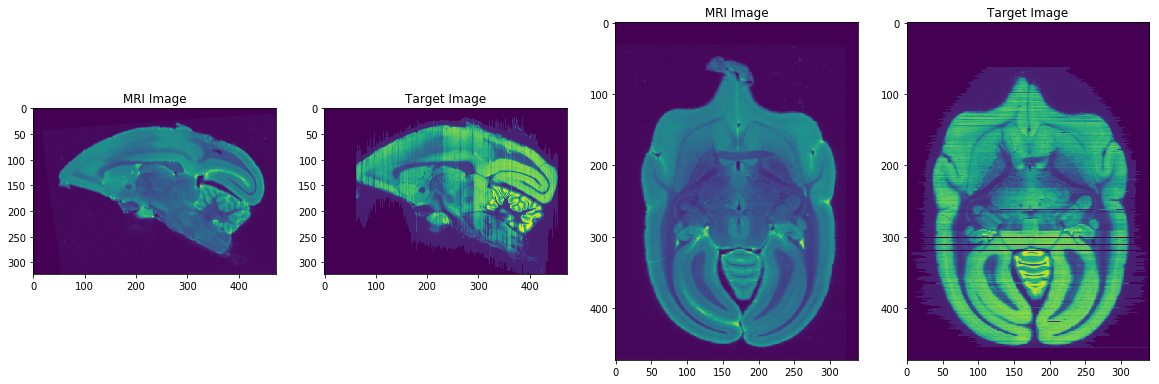

In [14]:
# apply the contrast adjustment to the MRI
mri_adjusted = (mri_image - lddmm.ccIbar[0].cpu().numpy()) * lddmm.ccCovIJ[0].cpu().numpy() / lddmm.ccVarI[0].cpu().numpy() + lddmm.ccJbar[0].cpu().numpy()

deformed_mri = (lddmm.applyThisTransform(mri_adjusted))[0][-1].cpu().numpy()

plt.figure()
plt.subplot(1,4,1)
plt.imshow(deformed_mri[:,:,150])
plt.title('MRI Image')
plt.subplot(1,4,2)
plt.imshow(outtarget[:,:,150])
plt.title('Target Image')
plt.subplot(1,4,3)
plt.imshow(deformed_mri[150,:,:])
plt.title('MRI Image')
plt.subplot(1,4,4)
plt.imshow(outtarget[150,:,:])
plt.title('Target Image')
plt.show()

## Mapping to Brain/MINDS atlas

In [15]:
del lddmm
torch.cuda.empty_cache()
lddmm = torch_lddmm.LDDMM(template=[template_image],target=[outtarget],costmask=None,outdir='../notebook/',do_affine=2,do_lddmm=0,a=8,niter=150,epsilon=5e-3,epsilonL=1e-7,epsilonT=2e-05,sigma=[20.0],sigmaR=10.0,optimizer='gdr',dx=dx,cc=1,update_epsilon=1,low_memory=0,v_scale=0.5)


Current parameters:
>    a               = 8 (smoothing kernel, a*(pixel_size))
>    p               = 2 (smoothing kernel power, p*2)
>    niter           = 150 (number of iterations)
>    epsilon         = 0.005 (gradient descent step size)
>    epsilonL        = 1e-07 (gradient descent step size, affine)
>    epsilonT        = 2e-05 (gradient descent step size, translation)
>    minbeta         = 0.0001 (smallest multiple of epsilon)
>    sigma           = [20.0] (matching term coefficient (0.5/sigma**2))
>    sigmaR          = 10.0 (regularization term coefficient (0.5/sigmaR**2))
>    nt              = 5 (number of time steps in velocity field)
>    do_lddmm        = 0 (perform LDDMM step, 0 = no, 1 = yes)
>    do_affine       = 2 (interleave linear registration: 0 = no, 1 = affine, 2 = rigid)
>    checkaffinestep = 0 (evaluate linear matching energy: 0 = no, 1 = yes)
>    im_norm_ms      = 0 (normalize image by mean and std: 0 = no, 1 = yes)
>    gpu_number      = 0 (index of CU

In [16]:
lddmm.run()

iter: 0, E = 47605.7578, ER = 0.0000, EM = 47605.7578, epd = 0.005000.
iter: 1, E= 45203.855, ER= 0.000, EM= 45203.855, epd= 0.005, time= 0.47s.
iter: 2, E= 44551.840, ER= 0.000, EM= 44551.840, epd= 0.005, time= 0.47s.
iter: 3, E= 43171.391, ER= 0.000, EM= 43171.391, epd= 0.005, time= 0.47s.
iter: 4, E= 41721.867, ER= 0.000, EM= 41721.867, epd= 0.005, time= 0.48s.
iter: 5, E= 40466.086, ER= 0.000, EM= 40466.086, epd= 0.005, time= 0.47s.
iter: 6, E= 39728.652, ER= 0.000, EM= 39728.652, epd= 0.005, time= 0.47s.
iter: 7, E= 39965.277, ER= 0.000, EM= 39965.277, epd= 0.005, time= 0.47s.
iter: 8, E= 40132.941, ER= 0.000, EM= 40132.941, epd= 0.005, time= 0.47s.
iter: 9, E= 40353.324, ER= 0.000, EM= 40353.324, epd= 0.005, time= 0.47s.
iter: 10, E= 40419.332, ER= 0.000, EM= 40419.332, epd= 0.005, time= 0.47s.
iter: 11, E= 40378.000, ER= 0.000, EM= 40378.000, epd= 0.005, time= 0.47s.
iter: 12, E= 40297.305, ER= 0.000, EM= 40297.305, epd= 0.005, time= 0.47s.
iter: 13, E= 40187.598, ER= 0.000, EM=

In [17]:
lddmm.setParams('do_affine',1)
lddmm.setParams('epsilonL',1e-7)
lddmm.setParams('epsilonT',2e-5)
lddmm.run()

Parameter 'do_affine' changed to '1'.
Parameter 'epsilonL' changed to '1e-07'.
Parameter 'epsilonT' changed to '2e-05'.
iter: 0, E = 38289.1875, ER = 0.0000, EM = 38289.1875, epd = 0.005000.
iter: 1, E= 37947.125, ER= 0.000, EM= 37947.125, epd= 0.005, time= 0.47s.
iter: 2, E= 37634.133, ER= 0.000, EM= 37634.133, epd= 0.005, time= 0.47s.
iter: 3, E= 37329.891, ER= 0.000, EM= 37329.891, epd= 0.005, time= 0.47s.
iter: 4, E= 37026.906, ER= 0.000, EM= 37026.906, epd= 0.005, time= 0.47s.
iter: 5, E= 36744.227, ER= 0.000, EM= 36744.227, epd= 0.005, time= 0.47s.
iter: 6, E= 36456.520, ER= 0.000, EM= 36456.520, epd= 0.005, time= 0.48s.
iter: 7, E= 36178.008, ER= 0.000, EM= 36178.008, epd= 0.005, time= 0.48s.
iter: 8, E= 35918.625, ER= 0.000, EM= 35918.625, epd= 0.005, time= 0.47s.
iter: 9, E= 35660.855, ER= 0.000, EM= 35660.855, epd= 0.005, time= 0.47s.
iter: 10, E= 35393.688, ER= 0.000, EM= 35393.688, epd= 0.005, time= 0.47s.
iter: 11, E= 35129.023, ER= 0.000, EM= 35129.023, epd= 0.005, time= 

iter: 107, E= 25891.604, ER= 0.000, EM= 25891.604, epd= 0.005, time= 0.47s.
iter: 108, E= 25881.535, ER= 0.000, EM= 25881.535, epd= 0.005, time= 0.47s.
iter: 109, E= 25871.814, ER= 0.000, EM= 25871.814, epd= 0.005, time= 0.47s.
iter: 110, E= 25862.402, ER= 0.000, EM= 25862.402, epd= 0.005, time= 0.47s.
iter: 111, E= 25853.340, ER= 0.000, EM= 25853.340, epd= 0.005, time= 0.47s.
iter: 112, E= 25844.629, ER= 0.000, EM= 25844.629, epd= 0.005, time= 0.47s.
iter: 113, E= 25836.240, ER= 0.000, EM= 25836.240, epd= 0.005, time= 0.47s.
iter: 114, E= 25828.174, ER= 0.000, EM= 25828.174, epd= 0.005, time= 0.47s.
iter: 115, E= 25820.354, ER= 0.000, EM= 25820.354, epd= 0.005, time= 0.47s.
iter: 116, E= 25812.826, ER= 0.000, EM= 25812.826, epd= 0.005, time= 0.47s.
iter: 117, E= 25805.600, ER= 0.000, EM= 25805.600, epd= 0.005, time= 0.47s.
iter: 118, E= 25798.688, ER= 0.000, EM= 25798.688, epd= 0.005, time= 0.47s.
iter: 119, E= 25792.045, ER= 0.000, EM= 25792.045, epd= 0.005, time= 0.47s.
iter: 120, E

In [18]:
lddmm.setParams('do_lddmm',1)
lddmm.run()

Parameter 'do_lddmm' changed to '1'.
iter: 0, E = 25639.6211, ER = 0.0000, EM = 25639.6211, epd = 0.005000.
iter: 1, E= 24450.354, ER= 0.335, EM= 24450.018, epd= 0.003, time= 2.36s.
iter: 2, E= 23520.895, ER= 1.165, EM= 23519.729, epd= 0.003, time= 2.36s.
iter: 3, E= 22734.814, ER= 2.328, EM= 22732.486, epd= 0.003, time= 2.36s.
iter: 4, E= 22040.553, ER= 3.731, EM= 22036.822, epd= 0.003, time= 2.36s.
iter: 5, E= 21466.236, ER= 5.277, EM= 21460.959, epd= 0.003, time= 2.36s.
iter: 6, E= 21006.465, ER= 6.856, EM= 20999.609, epd= 0.003, time= 2.37s.
iter: 7, E= 20633.332, ER= 8.398, EM= 20624.934, epd= 0.003, time= 2.36s.
iter: 8, E= 20321.422, ER= 9.890, EM= 20311.531, epd= 0.003, time= 2.36s.
iter: 9, E= 20069.312, ER= 11.323, EM= 20057.990, epd= 0.003, time= 2.36s.
iter: 10, E= 19858.504, ER= 12.698, EM= 19845.807, epd= 0.003, time= 2.36s.
iter: 11, E= 19673.352, ER= 14.013, EM= 19659.338, epd= 0.003, time= 2.36s.
iter: 12, E= 19511.350, ER= 15.276, EM= 19496.074, epd= 0.003, time= 2.37

iter: 106, E= 17279.631, ER= 89.859, EM= 17189.771, epd= 0.001, time= 2.37s.
iter: 107, E= 17280.039, ER= 90.094, EM= 17189.945, epd= 0.001, time= 2.37s.
iter: 108, E= 17280.361, ER= 90.259, EM= 17190.104, epd= 0.001, time= 2.36s.
iter: 109, E= 17280.617, ER= 90.375, EM= 17190.242, epd= 0.000, time= 2.37s.
iter: 110, E= 17280.803, ER= 90.456, EM= 17190.348, epd= 0.000, time= 2.36s.
iter: 111, E= 17280.938, ER= 90.513, EM= 17190.424, epd= 0.000, time= 2.37s.
iter: 112, E= 17281.033, ER= 90.553, EM= 17190.480, epd= 0.000, time= 2.37s.
iter: 113, E= 17281.104, ER= 90.582, EM= 17190.521, epd= 0.000, time= 2.36s.
iter: 114, E= 17281.150, ER= 90.602, EM= 17190.549, epd= 0.000, time= 2.36s.
iter: 115, E= 17281.186, ER= 90.616, EM= 17190.570, epd= 0.000, time= 2.36s.
iter: 116, E= 17281.213, ER= 90.626, EM= 17190.588, epd= 0.000, time= 2.37s.
iter: 117, E= 17281.230, ER= 90.633, EM= 17190.598, epd= 0.000, time= 2.37s.
iter: 118, E= 17281.244, ER= 90.638, EM= 17190.605, epd= 0.000, time= 2.37s.

In [19]:
lddmm.setParams('a',5)
lddmm.run()

Parameter 'a' changed to '5'.
iter: 0, E = 17222.3047, ER = 31.6865, EM = 17190.6191, epd = 0.005000.
iter: 1, E= 17124.428, ER= 33.165, EM= 17091.264, epd= 0.005, time= 2.37s.
iter: 2, E= 17048.086, ER= 34.792, EM= 17013.295, epd= 0.005, time= 2.36s.
iter: 3, E= 16981.623, ER= 36.597, EM= 16945.025, epd= 0.005, time= 2.36s.
iter: 4, E= 16932.104, ER= 38.468, EM= 16893.635, epd= 0.005, time= 2.36s.
iter: 5, E= 16971.975, ER= 40.616, EM= 16931.359, epd= 0.005, time= 2.37s.
iter: 6, E= 17039.445, ER= 41.724, EM= 16997.721, epd= 0.003, time= 2.36s.
iter: 7, E= 16972.594, ER= 43.042, EM= 16929.551, epd= 0.002, time= 2.37s.
iter: 8, E= 16903.166, ER= 43.790, EM= 16859.375, epd= 0.002, time= 2.36s.
iter: 9, E= 16889.174, ER= 45.044, EM= 16844.129, epd= 0.002, time= 2.37s.
iter: 10, E= 16860.863, ER= 45.932, EM= 16814.932, epd= 0.002, time= 2.37s.
iter: 11, E= 16856.562, ER= 47.198, EM= 16809.365, epd= 0.002, time= 2.37s.
iter: 12, E= 16840.436, ER= 48.220, EM= 16792.217, epd= 0.002, time= 2.

/opt/intelpython3/lib/python3.6/site-packages/matplotlib/contour.py:1230: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


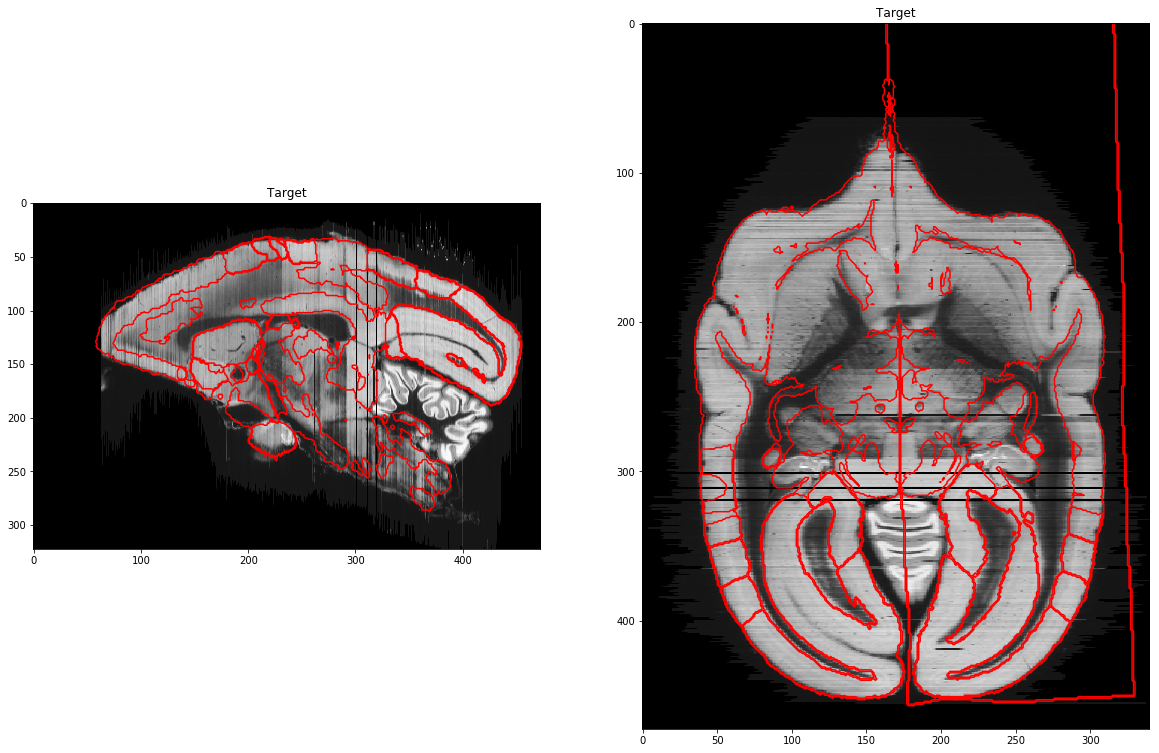

In [20]:
# transform annotation based on current transform
annotation_file_name = '../notebook/marmoset_annotation.img'
anno = nib.load(annotation_file_name).get_data().astype(np.float32)
deformed_anno,_,_,_ = lddmm.applyThisTransform(anno,interpmode='nearest')
deformed_anno = deformed_anno[-1].cpu().numpy()

# draw deformed annotation on target
levels = np.unique(deformed_anno[:,:,100])

plt.figure()
plt.subplot(1,2,1)
plt.imshow(outtarget[:,:,150],cmap='gray')
plt.title('Target')
for i in range(levels.shape[0]):
    plt.contour((deformed_anno[:,:,150]==levels[i])*1.0,0.999,colors='r')

levels = np.unique(deformed_anno[96,:,:])
plt.subplot(1,2,2)
plt.imshow(outtarget[150,:,:],cmap='gray')
plt.title('Target')
for i in range(levels.shape[0]):
    plt.contour((deformed_anno[150,:,:]==levels[i])*1.0,0.999,colors='r')

plt.show()